In [1]:
# import zlib
import gzip
import psycopg2
import pandas as pd

## 1. sepsis3 코호트에서 환자 admission id(hadm_id)를 찾는다.

In [2]:
sepsis3_df = pd.read_csv('../data/sepsis3-data/sepsis3-df.csv')

In [3]:
sepsis3_df.columns

Index(['icustay_id', 'hadm_id', 'excluded', 'intime', 'outtime', 'dbsource',
       'suspected_infection_time_poe', 'suspected_infection_time_poe_days',
       'specimen_poe', 'positiveculture_poe', 'antibiotic_time_poe',
       'blood_culture_time', 'blood_culture_positive', 'age', 'gender',
       'is_male', 'ethnicity', 'race_white', 'race_black', 'race_hispanic',
       'race_other', 'metastatic_cancer', 'diabetes', 'height', 'weight',
       'bmi', 'first_service', 'hospital_expire_flag', 'thirtyday_expire_flag',
       'icu_los', 'hosp_los', 'sepsis_angus', 'sepsis_martin',
       'sepsis_explicit', 'septic_shock_explicit', 'severe_sepsis_explicit',
       'sepsis_nqf', 'sepsis_cdc', 'sepsis_cdc_simple', 'elixhauser_hospital',
       'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'composite_outcome',
       'blood culture', 'suspicion_poe', 'abx_poe', 'sepsis-3', 'sofa>=2'],
      dtype='object')

In [4]:
hadm_ids = tuple(sepsis3_df.hadm_id.astype(int))

In [5]:
hadm_ids[:10]

(109307,
 181955,
 198650,
 121149,
 132255,
 162614,
 124231,
 101206,
 191980,
 164386)

In [6]:
type(hadm_ids[0])

int

## 2. Connect with mimic database

In [7]:
conn = psycopg2.connect(host='madigun.asuscomm.com', port='5432', database='mimic', user='grace', password="grace0410")
cur = conn.cursor()

## 3. Fetch required data

In [8]:
cur.execute('''SELECT DISTINCT(icd9_code)
             FROM diagnoses_icd
             WHERE hadm_id IN %s
                  AND seq_num = 1;''', (hadm_ids,))

In [10]:
icd9_results = cur.fetchall()

In [11]:
icd9_results

[('0031',),
 ('0041',),
 ('0059',),
 ('00845',),
 ('00863',),
 ('00869',),
 ('0088',),
 ('0090',),
 ('0091',),
 ('01890',),
 ('0270',),
 ('0279',),
 ('0310',),
 ('0340',),
 ('0360',),
 ('0380',),
 ('03810',),
 ('03811',),
 ('03812',),
 ('03819',),
 ('0382',),
 ('0383',),
 ('03840',),
 ('03841',),
 ('03842',),
 ('03843',),
 ('03844',),
 ('03849',),
 ('0388',),
 ('0389',),
 ('0400',),
 ('04082',),
 ('042',),
 ('0479',),
 ('048',),
 ('0499',),
 ('0520',),
 ('0530',),
 ('0543',),
 ('0545',),
 ('05472',),
 ('06641',),
 ('0701',),
 ('07020',),
 ('07030',),
 ('07032',),
 ('07041',),
 ('07044',),
 ('07054',),
 ('07070',),
 ('07071',),
 ('075',),
 ('0785',),
 ('07989',),
 ('07999',),
 ('08240',),
 ('0840',),
 ('0844',),
 ('0849',),
 ('08881',),
 ('08882',),
 ('0949',),
 ('0979',),
 ('1121',),
 ('1125',),
 ('11284',),
 ('11590',),
 ('11599',),
 ('1179',),
 ('1231',),
 ('1300',),
 ('1307',),
 ('135',),
 ('1363',),
 ('1369',),
 ('1410',),
 ('1414',),
 ('1418',),
 ('1420',),
 ('1430',),
 ('1440',),

In [14]:
len(icd9_results)

1610

In [17]:
icd_df = pd.DataFrame(icd9_results)
icd_df.columns = ['ori_code']
icd_df.head()

,ori_code
0,0031
1,0041
2,0059
3,00845
4,00863


According to mimic, "the code field for the ICD-9-CM Principal and Other Diagnosis Codes is six characters in length, with the decimal point implied between the third and fourth digit for all diagnosis codes other than the V codes. The decimal is implied for V codes between the second and third digit".

- XXXXXX -> XXX.XXX
- VXXXXX -> VXX.XXX

In [18]:
def reformat_icd9(code):
    if code.find('V') <0 :
        if len(code) == 3:
            return code
        else:
            return '.'.join([code[:3] , code[3:]])
    else:
        if len(code) ==3:
            return code
        else:
            return '.'.join([code[:3] , code[3:]])

In [19]:
icd_df['re_code'] = icd_df.ori_code.apply(lambda x: reformat_icd9(x) )

In [20]:
icd_df.head()

,ori_code,re_code
0,0031,003.1
1,0041,004.1
2,0059,005.9
3,00845,008.45
4,00863,008.63


ICD9 code 구조는 다음과 같다.  
- https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9
- https://www2.gov.bc.ca/assets/gov/health/practitioner-pro/medical-services-plan/diag-codes-index.pdf

Index
- 001 - 139.8 : Infections and parasitic diseases
- 140 - 239.9 : Neoplasms
- 240 - 279.9 : Endocrine, nutritional and metabolic diseases and immunity disorders
- 280 - 289.9 : Diseases of blood and blood forming organs
- 290 - 319 : mental disorders
- 320 - 389.9 : Diseases of nervous system and sense organs
- 390 - 459.9 : Disease of the circulatory system
- 460 - 519.9 : Disease of the respiratory system
- 520 - 579.9 : Disease of the digestive system
- 580 - 629.9 : Disease of genitourinary system
- 630 - 676.9 : Complications of pregnancy, childbirth and the puerperium
- 680 - 709.9 : diseases of the skin and subsutaneous tissue
- 710 - 739.9 : Diseases of musculoskeletal system and connective tissue
- 740 - 759.9 : Congenital anomalies
- 760 - 779.9 : Certain conditions originating in the perinatal period
- 780 - 799.9 : Symptoms, signs and ill-defined conditions
- 800 - 999.9 : injury and poisoning
- V01 - V82.9 : Supplementary classifications of factors influencing health status and contact with health services

In [21]:
# code categories with starting index
CODE_INDEX = {1: '001', 2: '140', 3: '240', 4: '280', 5: '290', 6: '320', 7: '390', 8: '460', 9: '520', 10: '580', 11: '630', 12: '680', 13: '710', 14: '740', 15: '760', 16: '780', 17: '800', 18: 'V01'}

In [22]:
def find_index_range_recursively(code, code_index_pos):
    if code > 999.9:
        raise CodeIndexError('Code not in appropriate range')
    
    try:
        if code >= float(CODE_INDEX[code_index_pos]):
            return find_index_range_recursively(code, code_index_pos+1)
        else:
            return code_index_pos - 1
    except ValueError:
            return code_index_pos - 1 

In [23]:
icd9_categories = {i:list() for i in CODE_INDEX.keys()}

def  get_category_counts(code):
    if code.find('V') >= 0:
        icd9_categories[18].append(code)
        return 18
    else:
        c_index = find_index_range_recursively(float(code), 1)
        icd9_categories[c_index].append(code)
        return c_index

In [24]:
icd_df.re_code.apply(lambda x: get_category_counts(x))

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
        ..
1600    18
1601    18
1602    18
1603    18
1604    18
1605    18
1606    18
1607    18
1608    18
1609    18
Name: re_code, Length: 1610, dtype: int64

In [25]:
# 각 카테고리별 진단 갯수를 파악해보기
for k, v in icd9_categories.items():
    print('{} : {}'.format(k, len(v)))

1 : 75
2 : 194
3 : 65
4 : 23
5 : 32
6 : 65
7 : 167
8 : 92
9 : 164
10 : 36
11 : 39
12 : 19
13 : 60
14 : 17
15 : 0
16 : 43
17 : 509
18 : 10


<BarContainer object of 18 artists>

([<matplotlib.axis.XTick at 0x11be574a8>,
 <a list of 18 Text xticklabel objects>)

Text(0, 0.5, 'counts')

Text(0.5, 1.0, 'Counts of ICD9 Code Categories')

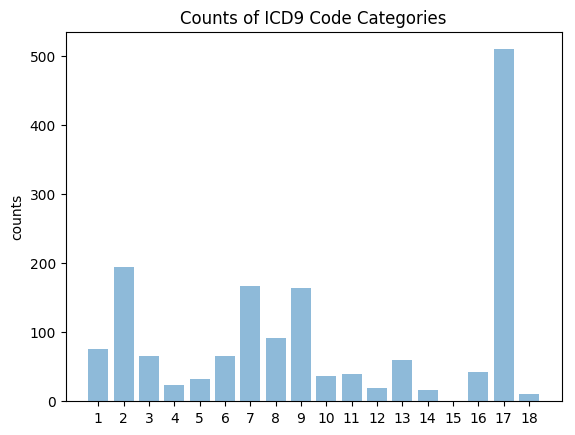

In [28]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

categories = icd9_categories.keys()
y_pos = np.arange(len(categories))
counts = [len(icd9_categories[k]) for k in categories]

plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, categories)
plt.ylabel('counts')
plt.title('Counts of ICD9 Code Categories')

plt.show()

## 3. Get embeddings

In [31]:
DIMENSION = 300

with gzip.open('../data/embedding/claims_codes_hs_300.txt.gz', 'rb') as f:
    file_content = f.read()

In [32]:
file_content = file_content.split(b'\n')
file_content = file_content[2:]

In [33]:
file_content  = list(filter(lambda x: x[0].find(b'IDX')>=0, map(lambda x: x.split(b' '), file_content)))

file_content = { i[0].decode('ASCII') : i[1:DIMENSION + 1] for i in file_content}

In [38]:
icd_embeddings = {}

not_found_codes = []
for ind, row in icd_df.iterrows():
    code = row['re_code']
    
    try:    
        code_emb = np.array(file_content['IDX_'+code])
        icd_embeddings[code] = code_emb.astype(float)

    except KeyError:
        print('IDX_'+code)
        not_found_codes.append(code)
#         not_found_codes.append(code[:-1])
#         file_content['IDX_'+code[:-1]]

IDX_004.1
IDX_027.9
IDX_209.25
IDX_532.61
IDX_534.41
IDX_695.14
IDX_800.24
IDX_800.25
IDX_800.60
IDX_800.65
IDX_800.71
IDX_801.15
IDX_801.19
IDX_801.23
IDX_801.24
IDX_801.35
IDX_801.52
IDX_801.65
IDX_801.72
IDX_801.75
IDX_801.80
IDX_803.15
IDX_803.16
IDX_803.25
IDX_803.62
IDX_803.72
IDX_804.21
IDX_804.22
IDX_804.25
IDX_804.36
IDX_804.76
IDX_806.07
IDX_851.21
IDX_851.25
IDX_851.35
IDX_851.83
IDX_852.32
IDX_852.45
IDX_853.16
IDX_861.03
IDX_861.13
IDX_863.83
IDX_904.53
IDX_927.01
IDX_999.84


In [49]:
for n_code in not_found_codes:
    print(n_code)
    closest_codes = list(filter(lambda x: x.find('_'+n_code[:-1])>=0, file_content.keys()))
    if len(closest_codes)==0:
        closest_codes = list(filter(lambda x: x.find('_'+n_code[:-2])>=0, file_content.keys()))
        
    print(closest_codes)
    closest_embs = []
    for cc in closest_codes:
        closest_embs.append(np.array(file_content[cc]).astype(float))
    icd_embeddings[n_code] = np.mean(np.array(closest_embs), axis=0)

004.1
['IDX_004.2', 'IDX_004.9', 'IDX_004.0', 'IDX_004.8', 'IDX_004.3']
027.9
['IDX_027.2', 'IDX_027.0', 'IDX_027.8']
209.25
['IDX_209.21', 'IDX_209.20', 'IDX_209.29', 'IDX_209.23', 'IDX_209.24']
532.61
['IDX_532.60']
534.41
['IDX_534.40']
695.14
['IDX_695.1', 'IDX_695.10', 'IDX_695.13', 'IDX_695.11', 'IDX_695.19', 'IDX_695.12', 'IDX_695.15']
800.24
['IDX_800.20', 'IDX_800.26', 'IDX_800.22', 'IDX_800.21', 'IDX_800.29', 'IDX_800.23']
800.25
['IDX_800.20', 'IDX_800.26', 'IDX_800.22', 'IDX_800.21', 'IDX_800.29', 'IDX_800.23']
800.60
['IDX_800.61']
800.65
['IDX_800.61']
800.71
['IDX_800.76', 'IDX_800.70']
801.15
['IDX_801.10', 'IDX_801.16', 'IDX_801.12', 'IDX_801.11']
801.19
['IDX_801.10', 'IDX_801.16', 'IDX_801.12', 'IDX_801.11']
801.23
['IDX_801.20', 'IDX_801.26', 'IDX_801.21', 'IDX_801.22', 'IDX_801.25', 'IDX_801.29']
801.24
['IDX_801.20', 'IDX_801.26', 'IDX_801.21', 'IDX_801.22', 'IDX_801.25', 'IDX_801.29']
801.35
['IDX_801.30', 'IDX_801.36', 'IDX_801.31', 'IDX_801.32']
801.52
['IDX_80

In [ ]:
# # 활용하지 않도록 권고된 코드가 입력된 경우가 있다.
# # http://www.icd9data.com/2012/Volume1/390-459/451-459/458/458.2.htm
# # There are 2 ICD-9-CM codes below 458.2 that define this diagnosis in greater detail. Do not use this code on a reimbursement claim.

# df[df.icd9_code_format=='458.2']
# # 458.2 (Iatrogenic Hypertension)하위 코드로는 456.21(Hypotension of hemodialysis), 456.29(Other iatrogenic hypertension)이 존재함으로 둘의 평균을 입력

# np_lower = np.array([file_content['IDX_458.21'], file_content['IDX_458.29']])
# np_lower = np_lower.astype(float)
# np_lower = np.mean(np_lower, axis=0)
# print(np_lower.shape)

# icd_embeddings['458.2'] =  np_lower

In [51]:
from sklearn.manifold import TSNE
from numpy import vstack
import seaborn as sns

In [52]:
data = vstack(icd_embeddings.values())

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data)

/Users/grace/workspace/keras/annon-env/lib/python3.7/site-packages/ipykernel/__main__.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1610 samples in 0.009s...
[t-SNE] Computed neighbors for 1610 samples in 0.997s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1610
[t-SNE] Computed conditional probabilities for sample 1610 / 1610
[t-SNE] Mean sigma: 1.248409
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.947540
[t-SNE] KL divergence after 300 iterations: 1.242331


In [53]:
df_emb = pd.DataFrame(icd_embeddings.items())
df_emb.columns = ['code', 'embedding']
df_emb['y'] = df_emb.code.apply(lambda x: get_category_counts(x))
df_emb.shape

(1610, 3)

<Figure size 1600x1000 with 0 Axes>

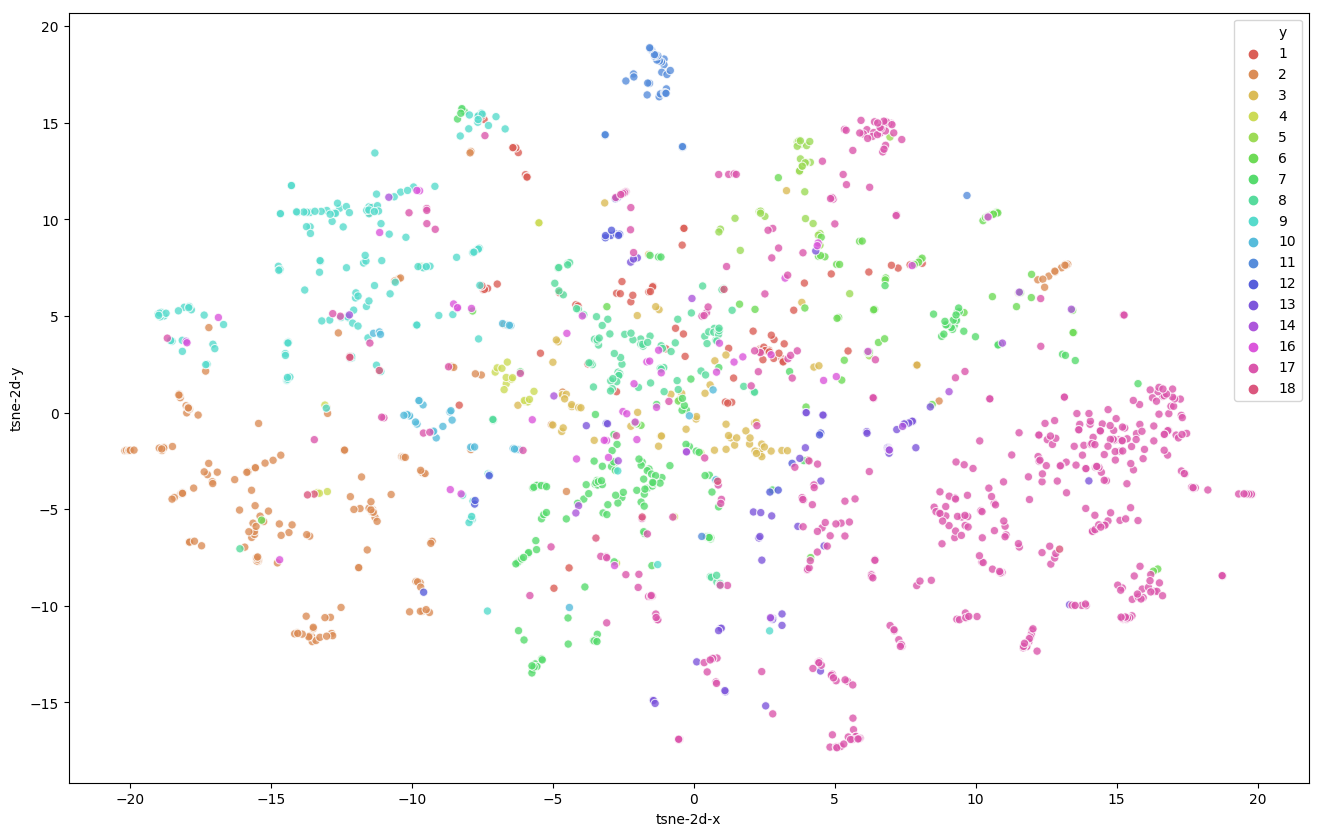

In [55]:
df_emb['tsne-2d-x'] = tsne_results[:,0]
df_emb['tsne-2d-y'] = tsne_results[:,1]
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-x", y="tsne-2d-y",
    hue="y",
    palette=sns.color_palette("hls", 17),
    data=df_emb,
    legend="full",
    alpha=0.8
)